# 1 Predicting Gender of Brazilian Names Using Deep Learning

## 1.1 Necessary libraries

In [1]:
import pandas as pd                       
import numpy as np
from tensorflow import keras
from keras.layers import Dense, LSTM, Bidirectional, Activation
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

## 1.2 Read the dataset

In [2]:
import requests
url = "https://data.brasil.io/dataset/genero-nomes/nomes.csv.gz"
filename = url.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(url)
    f.write(r.content)

df = pd.read_csv('nomes.csv.gz') 
df.head()

,alternative_names,classification,first_name,frequency_female,frequency_male,frequency_total,frequency_group,group_name,ratio
0,AILINE|ALEINE|ALIINE|ALINE|ALINER|ALINHE|ALINN...,F,AALINE,66.0,NaN,66,530550,ALINE,1.0
1,ARAAO|ARAO,M,AARAO,NaN,281.0,281,3526,ARAO,1.0
2,AHARON|AROM|ARON|ARYON|HARON,M,AARON,NaN,676.0,676,3442,ARON,1.0
3,ADA|ADAH|ADAR|ADHA|HADA,F,ABA,82.0,NaN,82,5583,ADA,1.0
4,NaN,M,ABADE,NaN,57.0,57,57,ABADE,1.0


### 1.2.1 Preparing the data

In [3]:
y = df['classification'].astype("category").cat.codes.values    # y labels into numbers 0 is F and 1 is M
names = df['first_name'].apply(lambda x: x.lower())             # input names

In [4]:
print("M : " + str(sum(y==1)))
print("F : " + str(sum(y==0)))
print(len(y))

M : 45537
F : 55250
100787


## 1.3 Encoding Words

In [5]:
#word encoding
maxlen = 20                                               # max lenght of a name

'''Define a vocabulary which corresponds to all the unique letters encountered'''
vocab = set(' '.join([str(i) for i in names]))            # creating a vocab
vocab.add('END')
len_vocab = len(vocab)

char_index = dict((c, i) for i, c in enumerate(vocab))    # creating a dictionary
''' The dictionary maps each letter of vocabulary to a number '''

# Builds an empty line with a 1 at the index of character
def set_flag(i):
    aux = np.zeros(len_vocab);
    aux[i] = 1
    return list(aux)

# Truncate names and create the matrix
def prepare_encod_names(X):
    vec_names = []
    trunc_name = [str(i)[0:maxlen] for i in X]  # consider only the first 20 characters
    for i in trunc_name:
        tmp = [set_flag(char_index[j]) for j in str(i)]
        for k in range(0,maxlen - len(str(i))):
            tmp.append(set_flag(char_index["END"]))
        vec_names.append(tmp)
    return vec_names

'''This is called one-hot-encoder and is based on the following papers: 
https://arxiv.org/abs/1707.07129 : Predicting the gender of Indonesian names
https://ieeexplore.ieee.org/document/8560790 : Advance Gender Prediction Tool...
 '''

'This is called one-hot-encoder and is based on the following papers: \nhttps://arxiv.org/abs/1707.07129 : Predicting the gender of Indonesian names\nhttps://ieeexplore.ieee.org/document/8560790 : Advance Gender Prediction Tool...\n '

In [6]:
x = prepare_encod_names(names.values)   # Now the names are encod as a vector of numbers

## 1.4 Split the data into test and train

In [7]:
# train, val, test set will be 60%, 20%, 25% of the dataset respectively
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=28)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=40)

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)

## 1.5 Building the BiLSTM Model

In [8]:
LSTMmodel = keras.Sequential()
LSTMmodel.add(Bidirectional(LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2), 
                            backward_layer=LSTM(128, return_sequences=False, go_backwards=True, dropout=0.2, recurrent_dropout=0.2),
                            input_shape=(maxlen,len_vocab)))
LSTMmodel.add(Dense(1, activity_regularizer=l2(0.002)))
LSTMmodel.add(Activation('sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
LSTMmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

LSTMhistory = LSTMmodel.fit(x_train, y_train, batch_size=256, epochs=50, validation_data=(x_val, y_val))
LSTMscores = LSTMmodel.evaluate(x_test, y_test)
print("Accuracy: %.2f%%" % (LSTMscores[1]*100))

Epoch 1/50
237/237 [==============================] - 77s 305ms/step - loss: 0.3769 - accuracy: 0.8307 - val_loss: 0.2414 - val_accuracy: 0.9107
Epoch 2/50
237/237 [==============================] - 72s 305ms/step - loss: 0.2441 - accuracy: 0.9109 - val_loss: 0.2074 - val_accuracy: 0.9291
Epoch 3/50
237/237 [==============================] - 73s 307ms/step - loss: 0.2162 - accuracy: 0.9234 - val_loss: 0.1982 - val_accuracy: 0.9331
Epoch 4/50
237/237 [==============================] - 73s 306ms/step - loss: 0.2011 - accuracy: 0.9314 - val_loss: 0.1861 - val_accuracy: 0.9392
Epoch 5/50
237/237 [==============================] - 73s 309ms/step - loss: 0.1919 - accuracy: 0.9370 - val_loss: 0.1748 - val_accuracy: 0.9453
Epoch 6/50
237/237 [==============================] - 73s 309ms/step - loss: 0.1822 - accuracy: 0.9404 - val_loss: 0.1706 - val_accuracy: 0.9461
Epoch 7/50
237/237 [==============================] - 73s 309ms/step - loss: 0.1748 - accuracy: 0.9445 - val_loss: 0.1659 - val_ac

## 1.6 Figures

<Figure size 432x288 with 0 Axes>

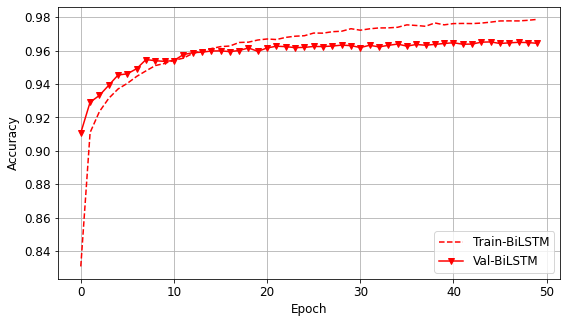

In [10]:
plt.figure(1)
plt.figure(figsize=(9,5))
plt.rcParams.update({'font.size':12})
plt.plot(LSTMhistory.history['accuracy'], 'r--')
plt.plot(LSTMhistory.history['val_accuracy'], 'r-v')
plt.grid('True')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train-BiLSTM', 'Val-BiLSTM'], loc='lower right')

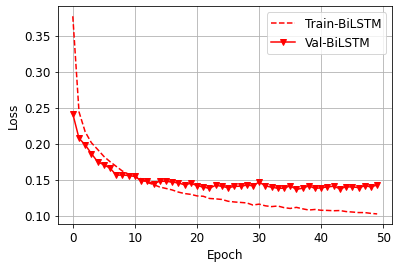

In [11]:
plt.figure(2)
plt.plot(LSTMhistory.history['loss'], 'r--')
plt.plot(LSTMhistory.history['val_loss'], 'r-v')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train-BiLSTM', 'Val-BiLSTM'], loc='upper right')
plt.grid('True')

## 1.7 Statistics

In [12]:
y_pred = (LSTMmodel.predict(x_test)>0.5).astype("int32")

In [13]:
from sklearn.metrics import precision_score, recall_score
print("precision {0:.4f} recall {1:.4f}".format(precision_score(y_test, y_pred), recall_score(y_test, y_pred)))

precision 0.9622 recall 0.9586


F1-Score: 0.9603